In [1]:
import os
os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")

'1'

In [2]:
# =========================================================
# 0) Setup (Colab installs) + Utilities
# =========================================================
!pip -q install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install numpy pandas scikit-learn einops tqdm
!pip -q install kagglehub tensorflow

import os, math, random, glob
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import average_precision_score, precision_recall_curve

def set_seed(seed=1337):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(1337)

if torch.cuda.is_available():
    device = torch.device("cuda")
    try:
        torch.backends.cudnn.benchmark = True
    except Exception:
        pass
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

use_cuda = device.type == "cuda"
use_mps = device.type == "mps"
print("Device:", device)

Device: cuda


In [3]:
# ===== PhysPrior‑UNet wrapper for mNDWS pipeline =====
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np

class PhysicsPrior(nn.Module):
    def __init__(self, kernel_radius=3):
        super().__init__()
        self.kernel_radius = kernel_radius
        self.register_buffer("angle_grid", self._make_angle_grid(kernel_radius))
    @staticmethod
    def _make_angle_grid(r):
        yy, xx = torch.meshgrid(torch.arange(-r, r+1), torch.arange(-r, r+1), indexing='ij')
        return torch.atan2(yy.float(), xx.float()+1e-8)
    def forward(self, prev_fire, u, v, slope, aspect, T, RH, NDVI, barrier=None):
        B, _, H, W = prev_fire.shape
        wind_angle = torch.atan2(v, u + 1e-8)
        wind_speed = torch.sqrt(u**2 + v**2)
        ws_norm = torch.clamp(wind_speed / 10.0, 0, 1)
        slope_norm = torch.clamp(slope, 0, 1)
        r = self.kernel_radius; K = 2*r + 1
        ang_flat = self.angle_grid.view(1,1,K*K,1,1).to(prev_fire)
        wa  = wind_angle.unsqueeze(2); asp = aspect.unsqueeze(2)
        aw  = (1.0 * ws_norm).unsqueeze(2)
        as_ = (1.0 * slope_norm).unsqueeze(2)
        dtheta_w = ang_flat - wa; dtheta_s = ang_flat - asp
        Ww = torch.exp(aw * torch.cos(dtheta_w))
        Ws = torch.exp(as_ * torch.cos(dtheta_s))
        kernel_flat = Ww * Ws
        kernel_flat = kernel_flat / (kernel_flat.sum(dim=2, keepdim=True) + 1e-8)
        ker = kernel_flat.reshape(B, K*K, H*W)
        pf_unf = F.unfold(prev_fire, kernel_size=K, padding=r)
        P1 = (pf_unf * ker).sum(dim=1).view(B,1,H,W)
        a0, a1, a2, a3 = 0.0, 0.04, 0.03, 0.8
        Damp = torch.sigmoid(a0 + a1*T - a2*RH + a3*NDVI)
        P = P1 * Damp
        if barrier is not None: P = P * (1.0 - barrier.clamp(0,1))
        Wx = torch.cos(wind_angle); Wy = torch.sin(wind_angle)
        return torch.cat([P, Wx, Wy, Damp], dim=1)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.SiLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.SiLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch, out_ch=1, base=64):
        super().__init__()
        self.down1 = DoubleConv(in_ch, base);   self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base, base*2);  self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(base*2, base*4);self.pool3 = nn.MaxPool2d(2)
        self.bottom= DoubleConv(base*4, base*8)
        self.up3   = nn.ConvTranspose2d(base*8, base*4, 2, 2)
        self.conv3 = DoubleConv(base*8, base*4)
        self.up2   = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.conv2 = DoubleConv(base*4, base*2)
        self.up1   = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.conv1 = DoubleConv(base*2, base)
        self.outc  = nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.down3(self.pool2(x2))
        xb = self.bottom(self.pool3(x3))
        x  = self.up3(xb); x = self.conv3(torch.cat([x, x3], dim=1))
        x  = self.up2(x);  x = self.conv2(torch.cat([x, x2], dim=1))
        x  = self.up1(x);  x = self.conv1(torch.cat([x, x1], dim=1))
        return self.outc(x)

# Losses (as provided)
class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5, alpha=0.5, reduction="mean"):
        super().__init__(); self.gamma, self.alpha, self.reduction = gamma, alpha, reduction
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        ce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        p_t = p*targets + (1-p)*(1-targets)
        loss = ((1-p_t)**self.gamma) * ce
        alpha_t = self.alpha*targets + (1-self.alpha)*(1-targets)
        loss = alpha_t * loss
        return loss.mean() if self.reduction=="mean" else loss.sum()

class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1.0): super().__init__(); self.smooth = smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        dims = (0,2,3)
        inter = (probs*targets).sum(dims)
        denom = probs.sum(dims) + targets.sum(dims)
        dice = (2*inter + self.smooth) / (denom + self.smooth)
        return 1 - dice.mean()

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1.0):
        super().__init__()
        self.alpha, self.beta, self.gamma, self.smooth = alpha, beta, gamma, smooth
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        dims = (0,2,3)
        TP = (p*targets).sum(dims)
        FP = (p*(1-targets)).sum(dims)
        FN = ((1-p)*targets).sum(dims)
        T = (TP + self.smooth) / (TP + self.alpha*FP + self.beta*FN + self.smooth)
        return (1 - T).pow(self.gamma).mean()

# Helper: channel mapping from your dataset
def name_to_idx(names):
    return {n: i for i, n in enumerate(names)}

# Wrapper: builds UNet input from mNDWS channels (+ optional PhysicsPrior features)
class PhysPriorUNet(nn.Module):
    def __init__(self, channel_names, mean, std, use_prior=True, include_raw=True, base=64, kernel_radius=3):
        super().__init__()
        self.channel_names = list(channel_names)
        self.mean = nn.Parameter(mean.view(1, -1, 1, 1), requires_grad=False)
        self.std  = nn.Parameter(std.view(1, -1, 1, 1),  requires_grad=False)
        self.use_prior = use_prior
        self.include_raw = include_raw
        self.prior = PhysicsPrior(kernel_radius=kernel_radius) if use_prior else None

        # Input channels = raw (if included) + 4 prior channels (P, Wx, Wy, Damp) if use_prior
        in_ch = (len(self.channel_names) if include_raw else 0) + (4 if use_prior else 0)
        self.unet = UNet(in_ch=in_ch, out_ch=1, base=base)

        # cache indices for speed
        idx = name_to_idx(self.channel_names)
        self.idx_prev   = idx.get("prev_fire")
        self.idx_u      = idx.get("u")
        self.idx_v      = idx.get("v")
        self.idx_slope  = idx.get("slope")
        self.idx_aspect = idx.get("aspect")
        self.idx_temp   = idx.get("temp")
        self.idx_rh     = idx.get("rh")
        self.idx_ndvi   = idx.get("ndvi")
        self.idx_bar    = idx.get("barrier", None)

        # Validate required channels for prior if enabled
        if self.use_prior:
            req = [self.idx_prev, self.idx_u, self.idx_v, self.idx_slope,
                   self.idx_aspect, self.idx_temp, self.idx_rh, self.idx_ndvi]
            if any(i is None for i in req):
                missing = ["prev_fire","u","v","slope","aspect","temp","rh","ndvi"]
                raise ValueError(f"PhysicsPrior requires channels: {missing}")

    def normalize(self, x):
        return (x - self.mean) / self.std

    def forward(self, X_raw):
        # X_raw: (B,C,H,W) with C == len(channel_names)
        Xn = self.normalize(X_raw)

        feats = []
        if self.use_prior:
            # Gather prior inputs by name
            def sel(i):
                return Xn[:, i:i+1] if i is not None else None
            P4 = self.prior(
                prev_fire = sel(self.idx_prev),
                u         = sel(self.idx_u),
                v         = sel(self.idx_v),
                slope     = sel(self.idx_slope),
                aspect    = sel(self.idx_aspect),
                T         = sel(self.idx_temp),
                RH        = sel(self.idx_rh),
                NDVI      = sel(self.idx_ndvi),
                barrier   = sel(self.idx_bar) if self.idx_bar is not None else None
            )  # (B,4,H,W)
            feats.append(P4)
        if self.include_raw:
            feats.append(Xn)

        X = torch.cat(feats, dim=1)
        return self.unet(X)  # logits (B,1,H,W)


In [4]:
# --- Use shared mNDWS DataPipeline outputs for NPZ tiles, splits, and stats ---
import importlib, math

if 'mndws_dp' in globals():
    mndws_dp = importlib.reload(mndws_dp)
else:
    import mNDWS_DataPipeline as mndws_dp

NPZ_ROOT = mndws_dp.NPZ_ROOT
print(f'Reusing NPZ tiles from pipeline at: {NPZ_ROOT}')

CHANNELS_FOR_MODEL = list(mndws_dp.CH_ORDER_BASE)  # UNet expects [prev,u,v,temp,rh,ndvi,slope,aspect,barrier]
paths = mndws_dp.WildfirePaths(NPZ_ROOT)

train_ds = mndws_dp.WildfireDataset(paths, split='train', max_samples=1200, channels=CHANNELS_FOR_MODEL)
val_ds   = mndws_dp.WildfireDataset(paths, split='eval',  max_samples=300,  channels=CHANNELS_FOR_MODEL)
test_ds  = mndws_dp.WildfireDataset(paths, split='test',  max_samples=300,  channels=CHANNELS_FOR_MODEL)

train_loader = mndws_dp.make_loader(train_ds, batch_size=16, upweight_positive=True)
val_loader   = mndws_dp.make_loader(val_ds,   batch_size=16)
test_loader  = mndws_dp.make_loader(test_ds,  batch_size=16)

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=2000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print(f'Loaders ready -> train {len(train_ds)}, val {len(val_ds)}, test {len(test_ds)}')
print(f'Channels configured: {train_ds.channels}')

def _idx(name_to_idx, key, default=None):
    return name_to_idx.get(key, default)

def aug_geo(X_raw, y, channel_names):
    # Geometry-aware augmentation that keeps u/v/aspect physically valid
    name_to_idx = {n:i for i,n in enumerate(channel_names)}
    i_u   = _idx(name_to_idx, 'u')
    i_v   = _idx(name_to_idx, 'v')
    i_asp = _idx(name_to_idx, 'aspect')

    if torch.rand(1).item() < 0.5:
        X_raw = torch.flip(X_raw, dims=[-1]); y = torch.flip(y, dims=[-1])
        if i_u is not None:   X_raw[:, i_u]   = -X_raw[:, i_u]
        if i_asp is not None: X_raw[:, i_asp] = torch.atan2(torch.sin(X_raw[:, i_asp]), -torch.cos(X_raw[:, i_asp]))
    if torch.rand(1).item() < 0.5:
        X_raw = torch.flip(X_raw, dims=[-2]); y = torch.flip(y, dims=[-2])
        if i_v is not None:   X_raw[:, i_v]   = -X_raw[:, i_v]
        if i_asp is not None: X_raw[:, i_asp] = -X_raw[:, i_asp]

    k = torch.randint(0, 4, (1,)).item()
    if k > 0:
        X_raw = torch.rot90(X_raw, k, dims=[-2, -1]); y = torch.rot90(y, k, dims=[-2, -1])
        if i_u is not None and i_v is not None and i_asp is not None:
            u = X_raw[:, i_u].clone(); v = X_raw[:, i_v].clone(); asp = X_raw[:, i_asp].clone()
            if k == 1:
                X_raw[:, i_u], X_raw[:, i_v], X_raw[:, i_asp] = -v,  u,  asp + math.pi / 2
            elif k == 2:
                X_raw[:, i_u], X_raw[:, i_v], X_raw[:, i_asp] = -u, -v,  asp + math.pi
            elif k == 3:
                X_raw[:, i_u], X_raw[:, i_v], X_raw[:, i_asp] =  v, -u,  asp - math.pi / 2
            X_raw[:, i_asp] = ((X_raw[:, i_asp] + math.pi) % (2 * math.pi)) - math.pi
    return X_raw, y

Reusing NPZ tiles from pipeline at: /scratch/jbm2rt/wildfire_npz_tiles_mndws_v1
Loaders ready -> train 1200, val 300, test 300
Channels configured: ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier']


In [5]:
# =========================================================
# 4) PhysPrior UNet training / evaluation loops
# =========================================================
import time

@torch.no_grad()
def pos_weight_from_loader(loader, max_batches=100):
    total_pos = 0
    total = 0
    for i, batch in enumerate(loader):
        y = batch["y"]
        total_pos += y.sum().item()
        total += y.numel()
        if i + 1 >= max_batches:
            break
    pos = max(total_pos, 1.0)
    neg = max(total - total_pos, 1.0)
    return torch.tensor(neg / pos, dtype=torch.float32, device=device)

pos_weight = pos_weight_from_loader(train_loader)
print(f"Computed pos_weight = {float(pos_weight):.3f}")

model = PhysPriorUNet(
    channel_names=train_ds.channels,
    mean=meanC,
    std=stdC,
    use_prior=True,
    include_raw=True,
    base=64,
    kernel_radius=3,
).to(device)

bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
dice_loss = SoftDiceLoss()
DICE_WEIGHT = 0.5

def combined_loss(logits, targets):
    return bce_loss(logits, targets) + DICE_WEIGHT * dice_loss(logits, targets)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
# Set number of epochs here
EPOCHS_UNET = 30
USE_AUG = True

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist = [], [], [], []
best_thr_val = 0.5

def _sync_device():
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps and hasattr(torch, "mps"):
        torch.mps.synchronize()

def maybe_augment(X_raw, y):
    if not USE_AUG:
        return X_raw, y
    return aug_geo(X_raw, y, train_ds.channels)

def train_unet_epoch():
    model.train()
    losses = []
    tiles_seen = 0
    for batch in tqdm(train_loader, desc="train UNet", leave=False):
        X_raw = batch["X_raw"]
        y = batch["y"]
        X_raw, y = maybe_augment(X_raw, y)
        X_raw = X_raw.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(X_raw)
        loss = combined_loss(logits, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        tiles_seen += X_raw.size(0)
    return float(np.mean(losses)), tiles_seen

@torch.no_grad()
def eval_unet(loader):
    model.eval()
    all_p, all_t = [], []
    for batch in tqdm(loader, desc="eval UNet", leave=False):
        X_raw = batch["X_raw"].to(device, non_blocking=True)
        y = batch["y"].to(device, non_blocking=True)
        probs = torch.sigmoid(model(X_raw)).flatten().cpu().numpy()
        targets = y.flatten().cpu().numpy()
        all_p.append(probs)
        all_t.append(targets)
    if not all_t:
        return 0.0, 0.0, 0.5
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    if t.sum() == 0:
        return 0.0, 0.0, 0.5
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    return float(ap), float(f1.max()), float(best_thr)

@torch.no_grad()
def test_at_thr(thr):
    model.eval()
    all_p, all_t = [], []
    for batch in tqdm(test_loader, desc="test UNet", leave=False):
        X_raw = batch["X_raw"].to(device, non_blocking=True)
        y = batch["y"].to(device, non_blocking=True)
        probs = torch.sigmoid(model(X_raw)).flatten().cpu().numpy()
        targets = y.flatten().cpu().numpy()
        all_p.append(probs)
        all_t.append(targets)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    ap = average_precision_score(t, p)
    yhat = (p >= thr).astype(np.float32)
    tp = (yhat * t).sum()
    fp = (yhat * (1 - t)).sum()
    fn = ((1 - yhat) * t).sum()
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    print(f"[UNet] TEST @thr={thr:.3f} | AP={ap:.4f} | P={prec:.3f} R={rec:.3f} F1={f1:.3f}")
    return ap, f1

epoch_times, epoch_tiles = [], []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in model.parameters() if p.requires_grad))
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)

best_val_ap = -1.0
best_state = None

for e in range(EPOCHS_UNET):
    _sync_device()
    epoch_start = time.perf_counter()
    tr_loss, tiles_seen = train_unet_epoch()
    _sync_device()
    epoch_duration = time.perf_counter() - epoch_start
    epoch_times.append(epoch_duration)
    epoch_tiles.append(tiles_seen)
    ap, f1, thr = eval_unet(val_loader)
    train_loss_hist.append(tr_loss)
    val_ap_hist.append(ap)
    val_f1_hist.append(f1)
    val_thr_hist.append(thr)
    print(f"[UNet] Epoch {e:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | thr≈{thr:.3f}")
    if ap > best_val_ap:
        best_val_ap = ap
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

if best_state is not None:
    model.load_state_dict(best_state)

_, _, best_thr_val = eval_unet(val_loader)
if val_thr_hist:
    val_thr_hist[-1] = best_thr_val
else:
    val_thr_hist.append(best_thr_val)
print(f"[UNet] Calibrated validation threshold ≈ {best_thr_val:.3f}")

test_ap_unet, test_f1_unet = test_at_thr(best_thr_val)

if epoch_times:
    avg_epoch = float(np.mean(epoch_times))
    std_epoch = float(np.std(epoch_times))
    total_time = float(np.sum(epoch_times))
    total_tiles = int(np.sum(epoch_tiles))
    throughput = float(total_tiles / total_time) if total_time > 0 else None
else:
    avg_epoch = std_epoch = throughput = None

if use_cuda:
    _sync_device()
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
elif use_mps and hasattr(torch, "mps"):
    try:
        peak_gpu_gb = float(torch.mps.current_allocated_memory() / (1024 ** 3))
    except AttributeError:
        peak_gpu_gb = None
else:
    peak_gpu_gb = None

@torch.no_grad()
def measure_latency(ds, repeats=50):
    if len(ds) == 0:
        return None
    model.eval()
    sample = ds[0]["X_raw"].unsqueeze(0).to(device)
    _sync_device()
    start = time.perf_counter()
    for _ in range(repeats):
        torch.sigmoid(model(sample))
    _sync_device()
    return (time.perf_counter() - start) / repeats

latency_s = measure_latency(test_ds, repeats=100)

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

Computed pos_weight = 32.908


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 00 | loss 1.3503 | VAL AP 0.3418 | VAL F1* 0.4479 | thr≈0.917


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 01 | loss 1.1961 | VAL AP 0.3841 | VAL F1* 0.4642 | thr≈0.913


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 02 | loss 1.1567 | VAL AP 0.3764 | VAL F1* 0.4654 | thr≈0.885


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 03 | loss 1.0620 | VAL AP 0.3406 | VAL F1* 0.4646 | thr≈0.924


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 04 | loss 1.0432 | VAL AP 0.4051 | VAL F1* 0.4680 | thr≈0.879


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 05 | loss 1.0446 | VAL AP 0.4045 | VAL F1* 0.4753 | thr≈0.908


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 06 | loss 1.0217 | VAL AP 0.4164 | VAL F1* 0.4835 | thr≈0.915


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 07 | loss 1.0148 | VAL AP 0.4208 | VAL F1* 0.4847 | thr≈0.920


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 08 | loss 0.9814 | VAL AP 0.4159 | VAL F1* 0.4804 | thr≈0.933


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 09 | loss 0.9898 | VAL AP 0.4132 | VAL F1* 0.4817 | thr≈0.919


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 10 | loss 0.9774 | VAL AP 0.4103 | VAL F1* 0.4741 | thr≈0.917


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 11 | loss 0.9805 | VAL AP 0.4176 | VAL F1* 0.4826 | thr≈0.918


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 12 | loss 1.0023 | VAL AP 0.4226 | VAL F1* 0.4818 | thr≈0.892


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 13 | loss 1.0119 | VAL AP 0.3982 | VAL F1* 0.4684 | thr≈0.894


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 14 | loss 0.9957 | VAL AP 0.4243 | VAL F1* 0.4837 | thr≈0.910


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 15 | loss 1.0032 | VAL AP 0.4106 | VAL F1* 0.4724 | thr≈0.893


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 16 | loss 0.9516 | VAL AP 0.4191 | VAL F1* 0.4751 | thr≈0.902


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 17 | loss 0.9496 | VAL AP 0.4319 | VAL F1* 0.4846 | thr≈0.908


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 18 | loss 0.9529 | VAL AP 0.4311 | VAL F1* 0.4906 | thr≈0.921


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 19 | loss 0.9485 | VAL AP 0.4284 | VAL F1* 0.4852 | thr≈0.905


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 20 | loss 0.9294 | VAL AP 0.4312 | VAL F1* 0.4885 | thr≈0.902


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 21 | loss 0.9393 | VAL AP 0.4314 | VAL F1* 0.4886 | thr≈0.900


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 22 | loss 0.9250 | VAL AP 0.4314 | VAL F1* 0.4911 | thr≈0.918


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 23 | loss 0.9104 | VAL AP 0.4332 | VAL F1* 0.4895 | thr≈0.904


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 24 | loss 0.9814 | VAL AP 0.4187 | VAL F1* 0.4782 | thr≈0.905


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 25 | loss 0.9621 | VAL AP 0.4251 | VAL F1* 0.4836 | thr≈0.916


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 26 | loss 0.9259 | VAL AP 0.4402 | VAL F1* 0.4920 | thr≈0.908


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 27 | loss 0.9298 | VAL AP 0.4299 | VAL F1* 0.4891 | thr≈0.920


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 28 | loss 0.9215 | VAL AP 0.4343 | VAL F1* 0.4851 | thr≈0.898


train UNet:   0%|          | 0/75 [00:00<?, ?it/s]

eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Epoch 29 | loss 0.9177 | VAL AP 0.4384 | VAL F1* 0.4937 | thr≈0.905


eval UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] Calibrated validation threshold ≈ 0.908


test UNet:   0%|          | 0/19 [00:00<?, ?it/s]

[UNet] TEST @thr=0.908 | AP=0.4105 | P=0.403 R=0.570 F1=0.473


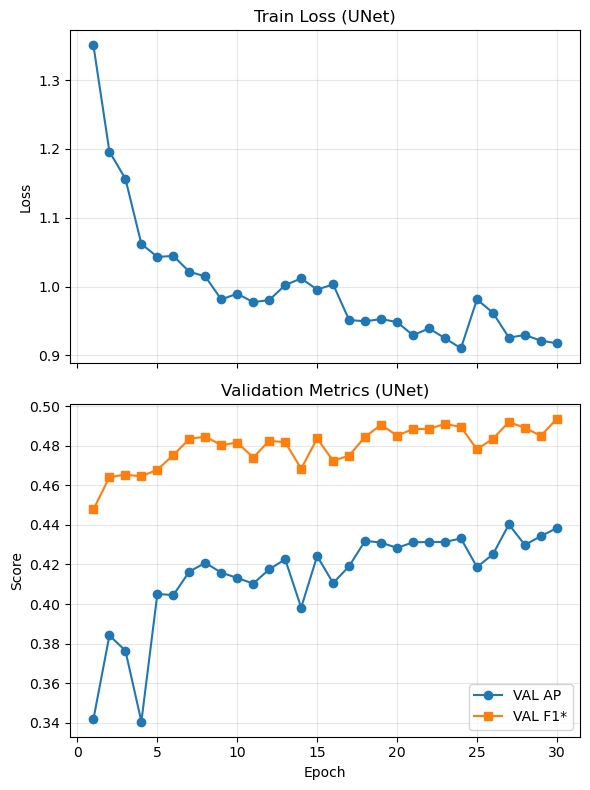

In [6]:
# =========================================================
# 5) Training curves (UNet)
# =========================================================
import matplotlib.pyplot as plt

if not train_loss_hist:
    print("Training history empty — run the training cell to populate curves.")
else:
    epochs = np.arange(1, len(train_loss_hist) + 1)
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    axes[0].plot(epochs, train_loss_hist, marker="o")
    axes[0].set_title("Train Loss (UNet)")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True, alpha=0.3)
    metric_epochs = np.arange(1, len(val_ap_hist) + 1)
    axes[1].plot(metric_epochs, val_ap_hist, marker="o", label="VAL AP")
    axes[1].plot(metric_epochs, val_f1_hist, marker="s", label="VAL F1*")
    axes[1].set_title("Validation Metrics (UNet)")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()

In [7]:
def _format_metric(val, unit=None):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[UNet] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[UNet] Computation metrics summary:
  Learnable parameters         7705921
  Avg. epoch wall time         3.400 s
  Epoch time stdev             1.196 s
  Training throughput          352.906 tiles/s
  Peak GPU memory              1.459 GB
  Inference latency (1 tile)   6.868 ms


VAL @thr: {'tp': 21655, 'fp': 29064, 'tn': 1162431, 'fn': 15650, 'precision': 0.4269603107315943, 'recall': 0.580485189652706, 'f1': 0.49202489741537514}
TEST @thr: {'tp': 22149, 'fp': 32764, 'tn': 1157206, 'fn': 16681, 'precision': 0.40334711270547896, 'recall': 0.5704094772081972, 'f1': 0.47254727867757523}


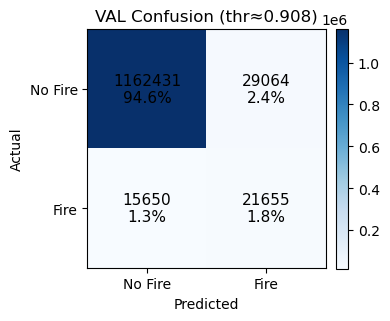

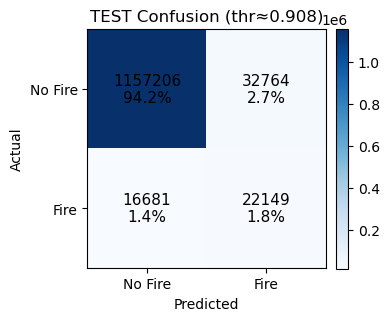

In [8]:
import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def confusion_at_thr(loader, thr):
    model.eval()
    tp = fp = tn = fn = 0
    for batch in loader:
        X_raw = batch["X_raw"].to(device, non_blocking=True)
        y = batch["y"].to(device, non_blocking=True)
        probs = torch.sigmoid(model(X_raw)).flatten().cpu().numpy()
        targets = y.flatten().cpu().numpy().astype(np.uint8)
        probs = np.nan_to_num(probs, nan=0.0)
        yhat = (probs >= thr).astype(np.uint8)
        tp += np.logical_and(yhat == 1, targets == 1).sum()
        fp += np.logical_and(yhat == 1, targets == 0).sum()
        tn += np.logical_and(yhat == 0, targets == 0).sum()
        fn += np.logical_and(yhat == 0, targets == 1).sum()
    tp, fp, tn, fn = map(int, (tp, fp, tn, fn))
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn, precision=float(prec), recall=float(rec), f1=float(f1))

def _conf_matrix_from_counts(stats):
    return np.array([[stats["tn"], stats["fp"]],
                     [stats["fn"], stats["tp"]]], dtype=np.int32)

def _plot_confusion(cm, title):
    total = cm.sum()
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["No Fire", "Fire"])
    ax.set_yticklabels(["No Fire", "Fire"])
    for (i, j), val in np.ndenumerate(cm):
        pct = (val / total * 100.0) if total else 0.0
        ax.text(j, i, f"{val}\n{pct:.1f}%", ha="center", va="center", color="black", fontsize=11)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()

val_stats = confusion_at_thr(val_loader, best_thr_val)
test_stats = confusion_at_thr(test_loader, best_thr_val)

print("VAL @thr:", val_stats)
print("TEST @thr:", test_stats)

_plot_confusion(_conf_matrix_from_counts(val_stats), f"VAL Confusion (thr≈{best_thr_val:.3f})")
_plot_confusion(_conf_matrix_from_counts(test_stats), f"TEST Confusion (thr≈{best_thr_val:.3f})")

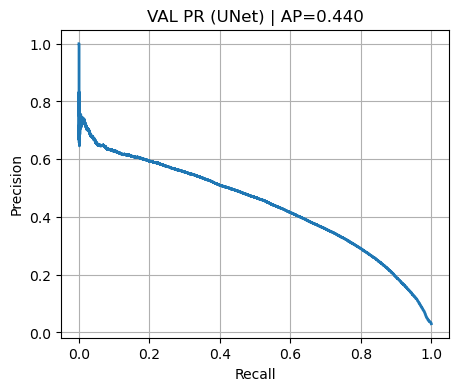

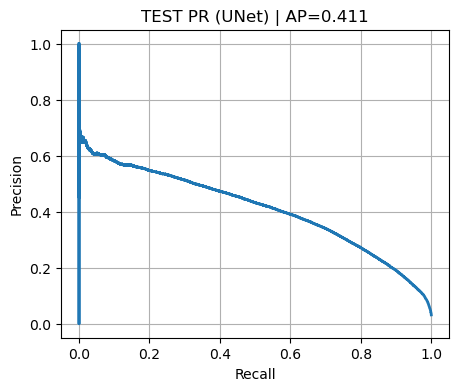

In [9]:
@torch.no_grad()
def pr_curve(loader, title="PR Curve (UNet)"):
    model.eval()
    ps, ts = [], []
    for batch in loader:
        X_raw = batch["X_raw"].to(device, non_blocking=True)
        y = batch["y"].to(device, non_blocking=True)
        probs = torch.sigmoid(model(X_raw)).flatten().cpu().numpy()
        targets = y.flatten().cpu().numpy()
        ps.append(probs)
        ts.append(targets)
    if not ps:
        print("Empty loader; skipping PR curve.")
        return
    p = np.concatenate(ps)
    t = np.concatenate(ts)
    prec, rec, _ = precision_recall_curve(t, p)
    ap = average_precision_score(t, p)
    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} | AP={ap:.3f}")
    plt.grid(True)
    plt.show()

pr_curve(val_loader, "VAL PR (UNet)")
pr_curve(test_loader, "TEST PR (UNet)")

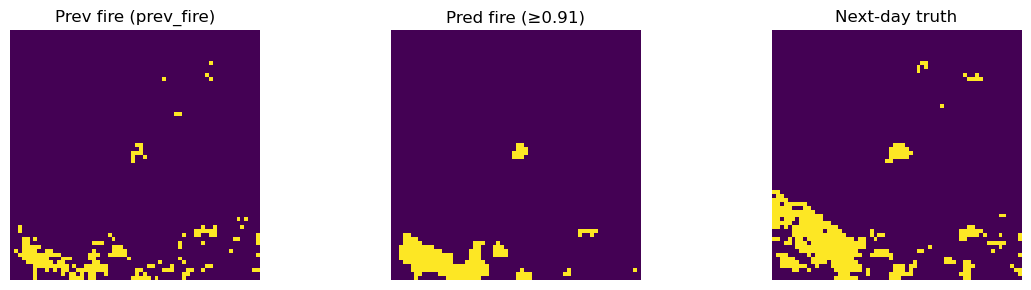

In [10]:
import matplotlib.pyplot as plt

@torch.no_grad()
def show_one(ds, i=0, thr=None):
    thr = best_thr_val if thr is None else thr
    b = ds[i]
    X_raw0 = b["X_raw"].unsqueeze(0).to(device)
    y = b["y"][0].numpy()
    probs = torch.sigmoid(model(X_raw0))[0, 0].cpu().numpy()
    pred = (probs >= float(thr)).astype(np.float32)

    channel_names = ds.channels
    prev_idx = channel_names.index("prev_fire") if "prev_fire" in channel_names else 0
    prev_img = b["X_raw"][prev_idx].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].imshow(prev_img, vmin=0, vmax=1); axs[0].set_title(f"Prev fire ({channel_names[prev_idx]})")
    axs[1].imshow(pred, vmin=0, vmax=1); axs[1].set_title(f"Pred fire (≥{thr:.2f})")
    axs[2].imshow(y, vmin=0, vmax=1); axs[2].set_title("Next-day truth")
    for a in axs:
        a.axis('off')
    plt.tight_layout(); plt.show()

show_one(test_ds, i=0)